In [1]:
%pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [2]:
!python -m pip install scipy tensorflow


In [3]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import os


In [4]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input

def preprocess_input(img):
    # Apply ResNet50 specific preprocessing
    img = resnet50_preprocess_input(img)
    return img


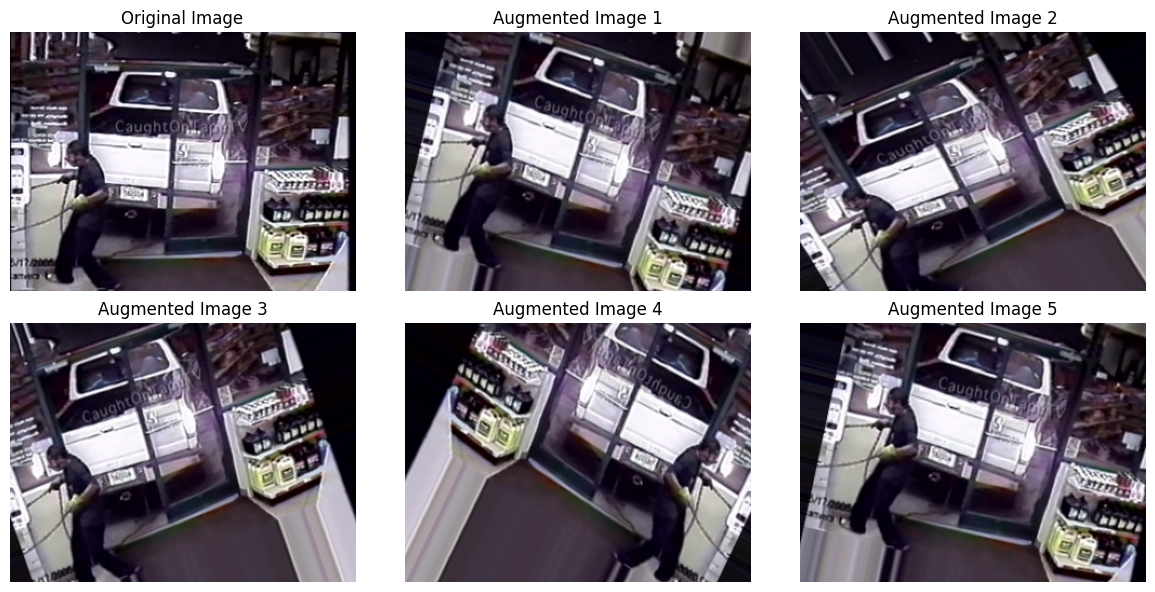

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

data_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load an example image
image_path = r'C:\Users\swadh\OneDrive\Desktop\crimedetection\Frames_for_Crime\Burglary\Burglary007_x264_fr0.jpg'
image = load_img(image_path, target_size=(240, 320))
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)


plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.imshow(image_array[0].astype(np.uint8))
plt.title('Original Image')
plt.axis('off')


aug_iter = data_generator.flow(image_array, batch_size=1)

# Display augmented images
for i in range(5):
    augmented_images = next(aug_iter)
    plt.subplot(2, 3, i + 2)
    plt.imshow(augmented_images[0].astype(np.uint8))
    plt.title(f'Augmented Image {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


BATCH_SIZE_TRAINING = 32
IMAGE_RESIZE = (240, 320)


train_data_generator = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=preprocess_input
)


train_generator = train_data_generator.flow_from_directory(
    r'C:\Users\swadh\OneDrive\Desktop\crimedetection',
    target_size=IMAGE_RESIZE,
    batch_size=BATCH_SIZE_TRAINING,
    class_mode='binary',
    classes=['Frames_for_Crime', 'Frames_for_Normal']
)


print(f'Found {train_generator.samples} images belonging to {train_generator.num_classes} classes.')


Found 2230 images belonging to 2 classes.
Found 2230 images belonging to 2 classes.


In [7]:
print(f'train_gen.class_indices: {train_generator.class_indices}')

train_gen.class_indices: {'Frames_for_Crime': 0, 'Frames_for_Normal': 1}


In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model


baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(240, 320, 3)))
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)


for layer in baseModel.layers:
    layer.trainable = False

In [9]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


In [10]:
from tensorflow.python.keras.callbacks import EarlyStopping
cb_early_stopper = EarlyStopping(monitor = 'loss', patience = 4)


In [11]:
NUM_EPOCHS = 10
STEPS_PER_EPOCH_TRAINING = train_generator.samples // BATCH_SIZE_TRAINING

fit_history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
    epochs=NUM_EPOCHS,
    callbacks=[cb_early_stopper]
)


Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.7669 - loss: 0.4426
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 777us/step - accuracy: 1.0000 - loss: 0.1050
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.9450 - loss: 0.1547
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 288us/step - accuracy: 0.9375 - loss: 0.0869
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.9747 - loss: 0.0931
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 205us/step - accuracy: 0.9375 - loss: 0.1494
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.9787 - loss: 0.0637
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 236us/step - accuracy: 1.0000 - loss: 0.0078
Epoch 9/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.9887 - loss: 0.0490
Epoch 10/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 229us/step - accuracy: 0.9688 - loss: 0.0499


In [12]:
print(fit_history.history.keys())

dict_keys(['accuracy', 'loss'])


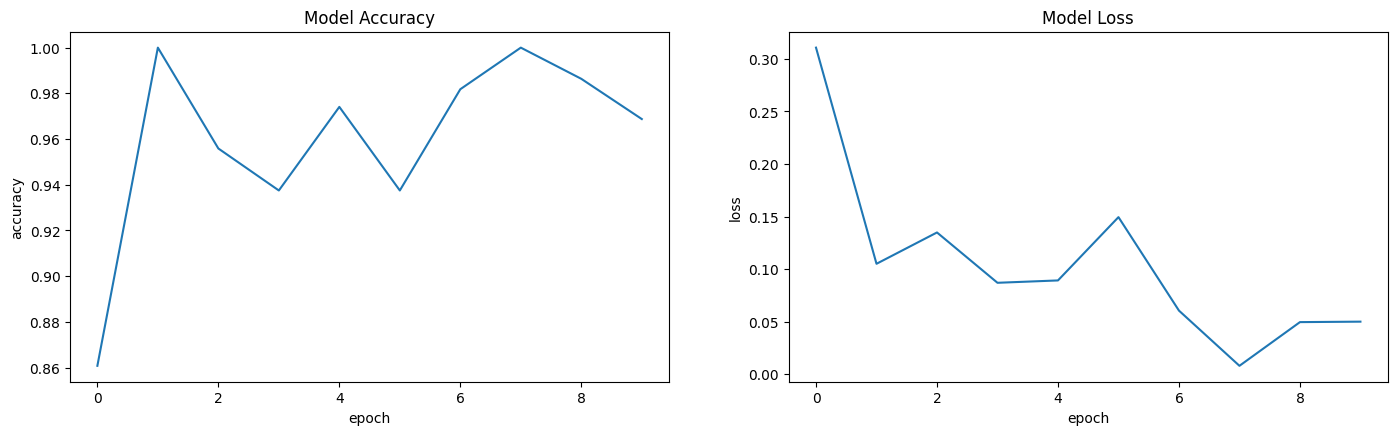

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize = (17,10))

plt.subplot(221)
plt.plot(fit_history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(222)
plt.plot(fit_history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the test data generator
test_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create a generator for the test data
test_generator = test_data_generator.flow_from_directory(
    r'C:\Users\swadh\OneDrive\Desktop\crimedetection',  # Replace with the path to the parent directory of test_crime and test_normal
    target_size=IMAGE_RESIZE,
    batch_size=BATCH_SIZE_TRAINING,
    class_mode='binary',
    classes=['test_crime', 'test_normal']  # Ensure these match your folder names
)

# Evaluate the model on the test data
evaluation = model.evaluate(test_generator)

print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")


Found 556 images belonging to 2 classes.


18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9671 - loss: 0.1191
Test Loss: 0.08957280218601227, Test Accuracy: 0.971222996711731


In [15]:
model.save('C:/Users/swadh/OneDrive/Desktop/crimedetection/resnet.h5')